<a href="https://colab.research.google.com/github/ddinesan/Manga/blob/master/Lecture_23_Worksheet_Quantum_Walks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quantum Walk


This is a worksheet prepared by Xi Dai for Lecture 24 of the reading course "Introduction to Quantum Computer Programming" (AMATH 900/ AMATH 495/ QIC 895) at the University of Waterloo.

Course Webpage: https://sites.google.com/view/quantum-computer-programming

Text followed in the course: Quantum Computing, An Applied Approach by Jack D. Hidary (2019)

In [ ]:
!pip install cirq
!pip install networkx

In [ ]:
import os

import numpy as np
from matplotlib import pyplot as plt
import scipy
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy.linalg import expm
from IPython.display import SVG, display
import networkx as nx
import sympy

import cirq
from cirq.contrib.svg import circuit_to_svg


def cprint(circuit):
  """Convert the cirq.Circuit to a temp svg and display + garbage collect."""
  with open("temp.svg", 'w+') as f:
    f.write(circuit_to_svg(circuit))
  display(SVG('temp.svg'))
  os.remove('temp.svg')

##Discrete time algorithm
A simple demonstration of the difference between classical and quantum walk.

###Classical Random Walk on a line

In [ ]:
def rd_line(t):
  x = 0
  coins = [(np.random.randint(0, 2) - 0.5) * 2 for ti in range(t)]
  return x + np.sum(coins)

def get_probability(x_array):
  hist_range = (min(x_array) - 0.5, max(x_array) + 0.5)
  hist_bins = int(max(x_array) - min(x_array) + 1)
  x_hist, x_edges = np.histogram(x_array, bins=hist_bins, range=hist_range)
  x_prob = x_hist / len(x_array)
  x_values = x_edges[:-1] + 0.5
  return x_values, x_prob, 

def get_expectation_std(x_values, x_prob):
  x_expectation = np.dot(x_values, x_prob)
  x_std = (np.dot([x**2 for x in x_values], x_prob) - x_expectation)**0.5
  return x_expectation, x_std

@interact
def plot_sample_rd_line(t=np.arange(10, 100), n_sample=1000):
  x_array = [rd_line(t) for _ in range(n_sample)]
  x_values, x_prob = get_probability(x_array)
  plt.plot(x_values, x_prob)
  x_expectation, x_std = get_expectation_std(x_values, x_prob)
  plt.figtext(0, 0.95, r"<x>={:.3f}, $\delta x$={:.3f}".format(
      x_expectation, x_std))

interactive(children=(Dropdown(description='t', options=(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2…

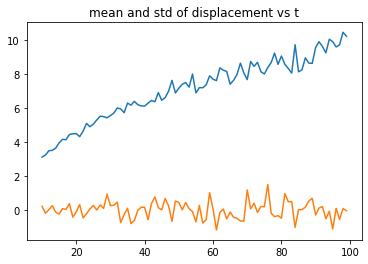

In [ ]:
def mean_std_rd_line(t_range, n_sample=200):
  x_mean_std_array = np.array([get_expectation_std(
      *get_probability(
          [rd_line(t) for _ in range(n_sample)]
      )
      ) for t in t_range])
  x_mean_array = x_mean_std_array[:, 0]
  x_std_array = x_mean_std_array[:, 1]
  return x_mean_array, x_std_array

t_range = np.arange(10, 100)
rd_mean_array, rd_std_array = mean_std_rd_line(t_range)
plt.plot(t_range, rd_std_array, label="std")
plt.plot(t_range, rd_mean_array, label="mean")
plt.title("mean and std of displacement vs t")
plt.show()

###Coined Quantum walk on a line


The quantized version of 1d random walk is the coined quantum walk on a line. Two registers are needed to perform this walk. The first resgister stores the position of the walker, the second plays the role of the coin. Coin toss is implemented as a Hadarmard gate.

In [ ]:
def coined_walk_update(amplitudes):
  """amplitudes has dimention n*2, 
  where first axis is size of walk, 
  second is amplitude of coin qubit
  """
  new_amplitudes = np.zeros_like(amplitudes, dtype=complex)
  for n in range(1, len(new_amplitudes)-1):
      new_amplitudes[n, 0] = np.sum(amplitudes[n-1]) / np.sqrt(2)
      new_amplitudes[n, 1] = np.subtract(*amplitudes[n+1]) / np.sqrt(2)
  return new_amplitudes

def coined_walk_initiate(n=50, initial="0"):
  x_values = np.arange(-n, n, 1)
  initial_amplitudes = np.zeros((len(x_values), 2), dtype=complex)
  if initial == "0":
    initial_amplitudes[n, 0] = 1
  elif initial == "1":
    initial_amplitudes[n, 1] = - 1
  elif initial == "equal":
    initial_amplitudes[n, 0] = 1 / np.sqrt(2)
    initial_amplitudes[n, 1] = - 1 / np.sqrt(2) * 1j
  else:
    raise ValueError("initial is either '0', '1', or 'equal'")
  return x_values, initial_amplitudes

def coined_walk(t, initial_amplitudes):
  amplitudes = initial_amplitudes
  for _ in range(t):
    amplitudes = coined_walk_update(amplitudes)
  return amplitudes

For coined quantum walk, the initial condition matters and the choice of the coin matters.  

In [ ]:
@interact
def plot_coined_walk(t=np.arange(10, 100), initial=["0", "1", "equal"]):
  x_values, initial_amplitudes = coined_walk_initiate(50, initial)
  amplitudes = coined_walk(t, initial_amplitudes)
  #print (x_values)
  #print (amplitudes)
  x_prob = np.sum(amplitudes * np.conj(amplitudes), axis=1)
  plt.plot(x_values, x_prob)
  x_expectation, x_std = get_expectation_std(x_values, x_prob)
  plt.figtext(0, 0.95, r"<x>={:.3f}, $\delta x$={:.3f}".format(
      x_expectation, x_std))

interactive(children=(Dropdown(description='t', options=(10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2…

In [ ]:
def mean_std_cqw_line(t_range):
  x_values, initial_amplitudes = coined_walk_initiate(n=100, initial="equal")
  amplitudes_array = [coined_walk(t, initial_amplitudes) for t in t_range]
  prob_array = [np.sum(
      amplitudes * np.conj(amplitudes), axis=1
      ) for amplitudes in amplitudes_array]
  x_mean_std_array = np.array([get_expectation_std(
      x_values, x_prob
      ) for x_prob in prob_array])
  x_mean_array = x_mean_std_array[:, 0]
  x_std_array = x_mean_std_array[:, 1]
  return x_mean_array, x_std_array

t_range = np.arange(10, 100)
cqw_mean_array, cqw_std_array = mean_std_cqw_line(t_range)

###Compare distribution

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


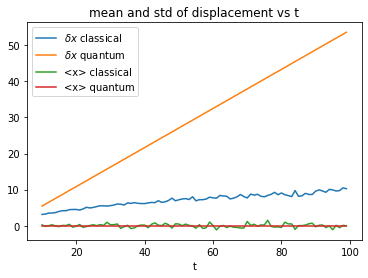

In [ ]:
plt.plot(t_range, rd_std_array, label="$\delta x$ classical")
plt.plot(t_range, cqw_std_array, label=r"$\delta x$ quantum")
plt.plot(t_range, rd_mean_array, label="<x> classical")
plt.plot(t_range, cqw_mean_array, label="<x> quantum")
plt.xlabel("t")
plt.legend()
plt.title("mean and std of displacement vs t")
plt.show()

##Continuous Time Algorithms

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
[-1. -1. -1.  3.]


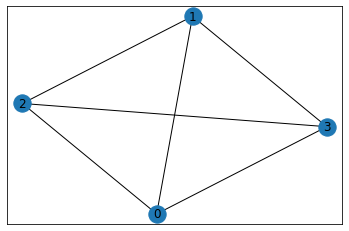

In [ ]:
graph = nx.complete_graph(4)
nx.draw_networkx(graph)
adjacency_mat = nx.adjacency_matrix(graph).toarray()
eigvals, _ = np.linalg.eigh(adjacency_mat)

print (adjacency_mat)
print (eigvals)

###Continuous Time Markov Chain

The classical counterpart of CTQW is Continuous Time Markov Chain. Its evolution follows:
\begin{align}
\vec{p} = e^{-Ht}\vec{p}(0)
\end{align}

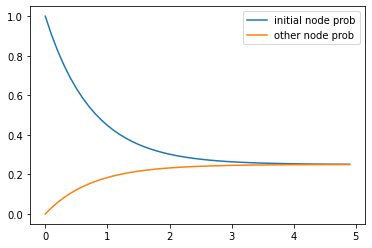

In [ ]:
def k4_crw(t):
  graph = nx.complete_graph(4)
  adjacency_mat = nx.adjacency_matrix(graph).toarray()
  stochastic_mat = adjacency_mat / np.sum(adjacency_mat, axis=0)
  evolve = scipy.linalg.expm((stochastic_mat - np.eye(4)) * t)
  probs = evolve[:,0]
  return probs

def prob_vs_time_crw(t_range):   
  probs = np.array([k4_crw(t) for t in t_range])
  initial_node_probs = probs[:, 0]
  other_node_probs = probs[:, 1]
  return initial_node_probs, other_node_probs

t_range = np.arange(0, 5, 0.1)
classical_probs = prob_vs_time_crw(t_range)

t_range = np.arange(0, 5, 0.1)
quantum_probs = prob_vs_time_ctqw(t_range, "None")
plt.plot(t_range, np.real(classical_probs[0]), label="initial node prob")
plt.plot(t_range, np.real(classical_probs[1]), label="other node prob")
plt.legend()
#plt.title("with identity")
plt.show()


### Continuous Time Quantum Walk

Next, We try continuous time quantum walk. Instead of restricting us to 1d. We also look at the more general case, of random walk on a graph. In this case each quantum state reprents a node on a graph. Instead of letting a coin register to decide the evolution, the quantum system evolve according to some Hamiltonian, typically just the adcacency matrix of the graph.

\begin{align}
\psi(t)=e^{-iHt}\psi(0)
\end{align}

---



In [ ]:
def k4_ctqw(t, ham):
  graph = nx.complete_graph(4)
  adjacency_mat = nx.adjacency_matrix(graph).toarray()
  q1, q2 = cirq.GridQubit.rect(1,2)
  c = cirq.Circuit()
  if ham == "None":
    hamiltonian = adjacency_mat + np.eye(4)
    c.append(cirq.H(q1))
    c.append(cirq.H(q2))
    cphase00_unitary = np.eye(4, dtype=complex)
    cphase00_unitary[0, 0] = np.exp(-4j * t)
    cphase00_gate = cirq.MatrixGate(cphase00_unitary)
    c.append(cphase00_gate.on(q1, q2))
    c.append(cirq.H(q1))
    c.append(cirq.H(q2))
  elif ham == "adjacency":
    hamiltonian = adjacency_mat
    unitary = scipy.linalg.expm(hamiltonian * 1j * t)
    gate = cirq.MatrixGate(unitary)
    c.append(gate.on(q1, q2))
  results = cirq.Simulator().simulate(c)
  return results

results = k4_ctqw(10, "adjacency")
print (results)

measurements: (no measurements)
output vector: (-0.591+0.161j)|00⟩ + (0.248-0.383j)|01⟩ + (0.248-0.383j)|10⟩ + (0.248-0.383j)|11⟩


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


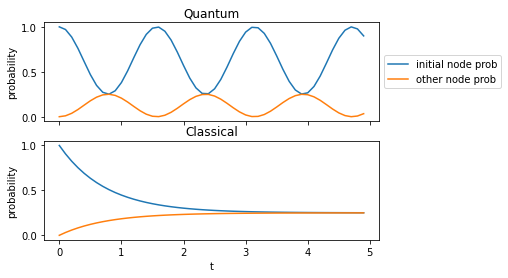

In [ ]:
def prob_vs_time_ctqw(t_range, ham):
  final_states = np.array([k4_ctqw(t, ham).final_state for t in t_range])
  initial_node_amp = final_states[:, 0]
  other_node_amp = final_states[:, 1]
  initial_node_probs = initial_node_amp * initial_node_amp.conj()
  other_node_probs = other_node_amp * other_node_amp.conj()
  return initial_node_probs, other_node_probs


_, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.set_title("Quantum")
ax1.set_ylabel("probability")
ax1.plot(t_range, quantum_probs[0], label="initial node prob")
ax1.plot(t_range, quantum_probs[1], label="other node prob")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax2.set_title("Classical")
ax2.set_ylabel("probability")
ax2.set_xlabel("t")
ax2.plot(t_range, classical_probs[0], label="initial node prob")
ax2.plot(t_range, classical_probs[1], label="other node prob")
# t_range = np.arange(0, 5, 0.1)
# quantum_probs = prob_vs_time_ctqw(t_range, "adjacency")
# plt.plot(t_range, np.real(quantum_probs[0]), label="initial node prob")
# plt.plot(t_range, np.real(quantum_probs[1]), label="other node prob")
# plt.legend()
# plt.title("without identity")
# plt.show()

###Continuous time algorithms for a star graph


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


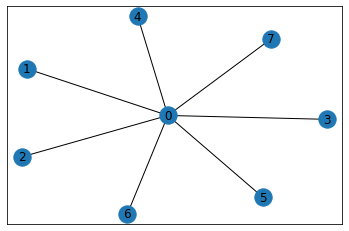

In [ ]:
graph = nx.star_graph(7)
nx.draw_networkx(graph)
adjacency_mat = nx.adjacency_matrix(graph).toarray()
stochastic_mat = adjacency_mat / np.sum(adjacency_mat, axis=0)

t_range = np.arange(0, 10, 0.1)
quantum_probs = np.zeros((len(t_range), 8))
classical_probs = np.zeros((len(t_range), 8))
for i, t in enumerate(t_range):
  q1 = cirq.NamedQubit("q1")
  q2 = cirq.NamedQubit("q2")
  q3 = cirq.NamedQubit("q3")
  c = cirq.Circuit()
  unitary = scipy.linalg.expm(1j * adjacency_mat * t)
  gate = cirq.MatrixGate(unitary)
  c.append(gate.on(q1, q2, q3))
  result = cirq.Simulator().simulate(c).final_state
  quantum_probs[i] = np.abs(result) ** 2

  classical_ev = scipy.linalg.expm((stochastic_mat - np.eye(8)) * t)
  classical_probs[i] = classical_ev[:, 0]

####start at the center node

quatum case : max other node prob=0.14283
classical case : max other node prob=0.07143


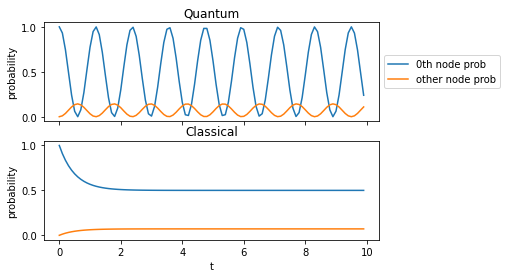

In [ ]:
_, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.set_title("Quantum")
ax1.set_ylabel("probability")
ax1.plot(t_range, quantum_probs[:, 0], label="0th node prob")
ax1.plot(t_range, quantum_probs[:, 1], label="other node prob")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax2.set_title("Classical")
ax2.set_ylabel("probability")
ax2.set_xlabel("t")
ax2.plot(t_range, classical_probs[:, 0], label="0th node prob")
ax2.plot(t_range, classical_probs[:, 1], label="other node prob")

print ("quatum case : max other node prob={:.5f}".format(max(quantum_probs[:, 1])))
print ("classical case : max other node prob={:.5f}".format(max(classical_probs[:, 1])))

####start at a peripheral node

quatum case : max other node prob=0.08159
classical case : max other node prob=0.07142


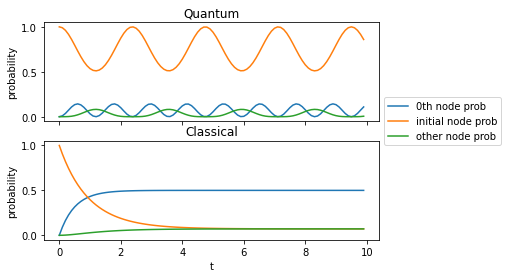

In [ ]:
for i, t in enumerate(t_range):
  q1 = cirq.NamedQubit("q1")
  q2 = cirq.NamedQubit("q2")
  q3 = cirq.NamedQubit("q3")
  c = cirq.Circuit()
  unitary = scipy.linalg.expm(1j * adjacency_mat * t)
  gate = cirq.MatrixGate(unitary)
  c.append(cirq.X.on(q3))
  c.append(gate.on(q1, q2, q3))
  result = cirq.Simulator().simulate(c).final_state
  quantum_probs[i] = np.abs(result) ** 2

  classical_ev = scipy.linalg.expm((stochastic_mat - np.eye(8)) * t)
  classical_probs[i] = classical_ev[:, 1]

_, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.set_title("Quantum")
ax1.set_ylabel("probability")
ax1.plot(t_range, quantum_probs[:, 0], label="0th node prob")
ax1.plot(t_range, quantum_probs[:, 1], label="initial node prob")
ax1.plot(t_range, quantum_probs[:, 2], label="other node prob")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0))
ax2.set_title("Classical")
ax2.set_ylabel("probability")
ax2.set_xlabel("t")
ax2.plot(t_range, classical_probs[:, 0], label="oth node prob")
ax2.plot(t_range, classical_probs[:, 1], label="initial node prob")
ax2.plot(t_range, classical_probs[:, 2], label="other node prob")

print ("quatum case : max other node prob={:.5f}".format(max(quantum_probs[:, 2])))

print ("classical case : max other node prob={:.5f}".format(max(classical_probs[:, 2])))

##References

["Quantum walks and search algorithms" by R. Portugal](https://link.springer.com/book/10.1007/978-1-4614-6336-8)

["Quantum Computing: An Applied Approach" by J. Hidary](https://www.springer.com/gp/book/9783030239213)